Epoch 1/20


C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


772/772 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.8643 - loss: 0.3298 - val_accuracy: 0.9340 - val_loss: 0.1706
Epoch 2/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9337 - loss: 0.1879 - val_accuracy: 0.9437 - val_loss: 0.1492
Epoch 3/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9488 - loss: 0.1462 - val_accuracy: 0.9484 - val_loss: 0.1255
Epoch 4/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9604 - loss: 0.1109 - val_accuracy: 0.9754 - val_loss: 0.0739
Epoch 5/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9702 - loss: 0.0866 - val_accuracy: 0.9775 - val_loss: 0.0703
Epoch 6/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9718 - loss: 0.0788 - val_accuracy: 0.9790 - val_loss: 0.0701
Epoch 7/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9745 - loss: 0.0745 - val_accuracy: 0.9828 - val_loss: 0.0500
Epoch 8/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9750 - loss: 0.0685 - val_accurac

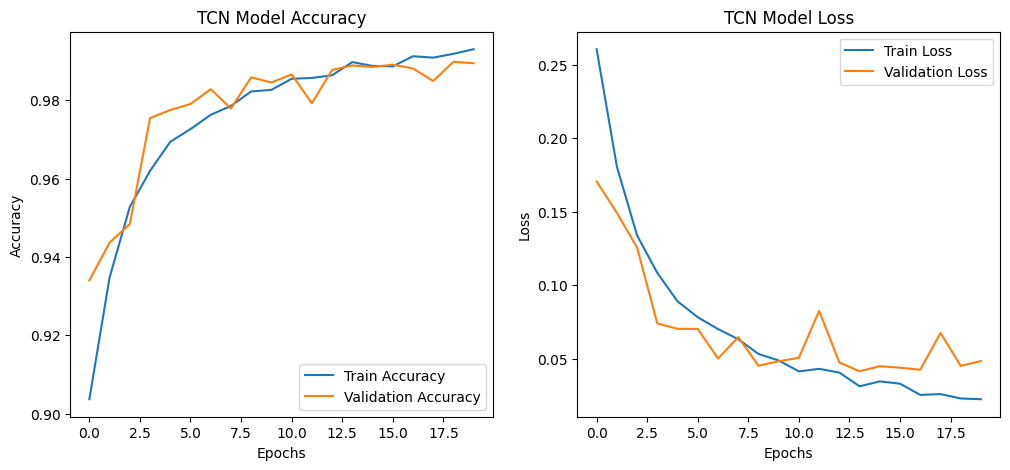

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


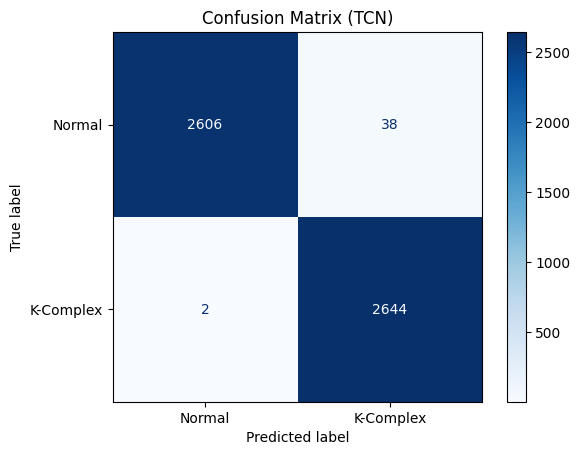

Classification Report (TCN):
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99      2644
   K-Complex       0.99      1.00      0.99      2646

    accuracy                           0.99      5290
   macro avg       0.99      0.99      0.99      5290
weighted avg       0.99      0.99      0.99      5290



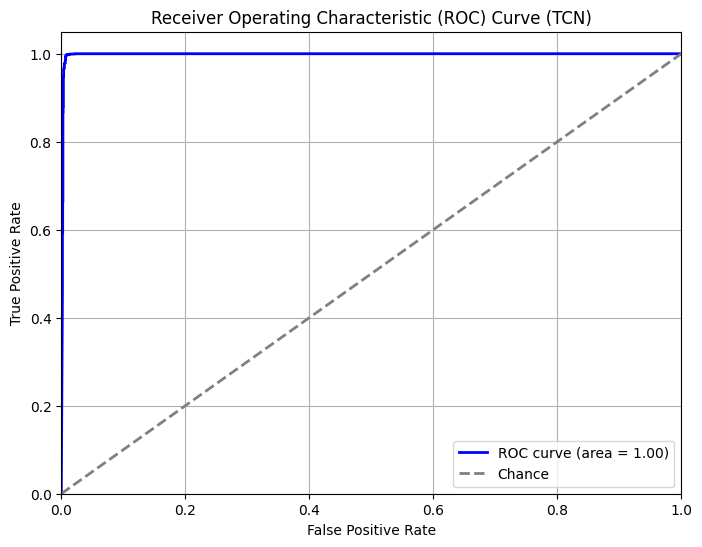

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SpatialDropout1D
import os
from tensorflow.keras.utils import to_categorical

# Path where all your files are stored
folder_path = 'D:/OneDrive_2024-12-27/Segmented by seperating spindles/Balanced_segmented/'

# Collect all Excel file paths in the folder
file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.xlsx')]

# Initialize empty lists to store features and labels
X_list, y_list = [], []

# Load and combine data from all files
for file_path in file_paths:
    data = pd.read_excel(file_path)
    X_list.append(data.iloc[:, :-1].values)  # All columns except the last
    y_list.append(data.iloc[:, -1].values)  # The last column

# Concatenate data from all files
X = np.vstack(X_list)
y = np.hstack(y_list)

# Normalize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data for CNN (add a channel dimension)
X_scaled_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled_reshaped, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Convert labels to categorical format
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

# Define the TCN model
model_tcn = Sequential([
    # First Temporal Convolution Layer
    Conv1D(64, kernel_size=3, dilation_rate=1, activation='relu', padding='causal', input_shape=(200, 1)),
    SpatialDropout1D(0.2),
    MaxPooling1D(pool_size=2),
    
    # Second Temporal Convolution Layer
    Conv1D(128, kernel_size=3, dilation_rate=2, activation='relu', padding='causal'),
    SpatialDropout1D(0.2),
    MaxPooling1D(pool_size=2),
    
    # Third Temporal Convolution Layer
    Conv1D(256, kernel_size=3, dilation_rate=4, activation='relu', padding='causal'),
    SpatialDropout1D(0.3),
    MaxPooling1D(pool_size=2),
    
    # Flatten the results
    Flatten(),
    
    # Fully connected layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Output layer for binary classification
])

# Compile the model
model_tcn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_tcn = model_tcn.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=20,  # You can adjust epochs as needed
    batch_size=32,
    verbose=1
)

# Evaluate the model
test_loss_tcn, test_accuracy_tcn = model_tcn.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Loss (TCN): {test_loss_tcn:.4f}")
print(f"Test Accuracy (TCN): {test_accuracy_tcn:.4f}")

# Visualize training history (reuse your existing plotting code)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_tcn.history['accuracy'], label='Train Accuracy')
plt.plot(history_tcn.history['val_accuracy'], label='Validation Accuracy')
plt.title('TCN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_tcn.history['loss'], label='Train Loss')
plt.plot(history_tcn.history['val_loss'], label='Validation Loss')
plt.title('TCN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Confusion Matrix and Classification Report (reuse your existing code)
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Predict the classes for the test set
y_pred_tcn = model_tcn.predict(X_test)
y_pred_classes_tcn = np.argmax(y_pred_tcn, axis=1)

# Generate the confusion matrix
conf_matrix_tcn = confusion_matrix(y_test, y_pred_classes_tcn)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_tcn, display_labels=['Normal', 'K-Complex'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (TCN)")
plt.show()

# Calculate precision, recall, and F1-score
report_tcn = classification_report(y_test, y_pred_classes_tcn, target_names=['Normal', 'K-Complex'])
print("Classification Report (TCN):")
print(report_tcn)

# ROC curve and AUC (reuse your existing code)
from sklearn.metrics import roc_curve, auc

fpr_tcn, tpr_tcn, _ = roc_curve(y_test_cat[:, 1], y_pred_tcn[:, 1])  # ROC for the positive class (K-Complex)
roc_auc_tcn = auc(fpr_tcn, tpr_tcn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_tcn, tpr_tcn, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_tcn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (TCN)')
plt.legend(loc='lower right')
plt.grid()
plt.show()
